##  Data Processing

In [9]:
import pandas as pd


In [10]:
pd.read_csv('results.csv')

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False
...,...,...,...,...,...,...,...,...,...
48202,2025-03-25,Israel,Norway,2,4,FIFA World Cup qualification,Debrecen,Hungary,True
48203,2025-03-25,Liechtenstein,Kazakhstan,0,2,FIFA World Cup qualification,Vaduz,Liechtenstein,False
48204,2025-03-25,North Macedonia,Wales,1,1,FIFA World Cup qualification,Skopje,North Macedonia,False
48205,2025-03-25,Gibraltar,Czech Republic,0,4,FIFA World Cup qualification,Faro-Loulé,Portugal,True


In [11]:
# import os
# os.getcwd()
# os.chdir('/Users/zhanghao/Downloads/Spring Course/Data Science with Machine Learning/Coursework/Project/pythonProject')

In [12]:
# Load the dataset
results_df = pd.read_csv("results.csv")
former_names_df = pd.read_csv("former_names.csv")


In [13]:
# Create a dictionary of former → current name mappings
former_to_current = dict(zip(former_names_df["former"], former_names_df["current"]))

In [14]:
# Print some mapping relationships to see the effect
print("Sample country name mapping (first 5)：")
for k, v in list(former_to_current.items())[:5]:
    print(f"{k} → {v}")

# Apply mapping to create standardized home and away team fields
results_df["home_team_standardized"] = results_df["home_team"].replace(former_to_current)
results_df["away_team_standardized"] = results_df["away_team"].replace(former_to_current)

# Standardize the country field as well
results_df["country_standardized"] = results_df["country"].replace(former_to_current)

# Check the conversion effect (first 10 rows)
results_df[[
    "home_team", "home_team_standardized",
    "away_team", "away_team_standardized",
    "country", "country_standardized"
]].head(10)

Sample country name mapping (first 5)：
Dahomey → Benin
Upper Volta → Burkina Faso
Netherlands Antilles → Curaçao
Bohemia → Czechoslovakia
Bohemia and Moravia → Czechoslovakia


,home_team,home_team_standardized,away_team,away_team_standardized,country,country_standardized
0,Scotland,Scotland,England,England,Scotland,Scotland
1,England,England,Scotland,Scotland,England,England
2,Scotland,Scotland,England,England,Scotland,Scotland
3,England,England,Scotland,Scotland,England,England
4,Scotland,Scotland,England,England,Scotland,Scotland
5,Scotland,Scotland,Wales,Wales,Scotland,Scotland
6,England,England,Scotland,Scotland,England,England
7,Wales,Wales,Scotland,Scotland,Wales,Wales
8,Scotland,Scotland,England,England,Scotland,Scotland
9,Scotland,Scotland,Wales,Wales,Scotland,Scotland


In [15]:
# Save the result data with standardized country names for later use
results_df.to_csv("results_standardized.csv", index=False)

In [16]:
# Remove old fields and keep standardized country names
# ============================================

# Delete old fields: original home_team, away_team, country
results_df_cleaned = results_df.drop(columns=["home_team", "away_team", "country"])

# Rename the standardized fields to unified field names
results_df_cleaned.rename(columns={
    "home_team_standardized": "home_team",
    "away_team_standardized": "away_team",
    "country_standardized": "country"
}, inplace=True)

# View the first few lines after processing
results_df_cleaned.head()

,date,home_score,away_score,tournament,city,neutral,home_team,away_team,country
0,1872-11-30,0,0,Friendly,Glasgow,False,Scotland,England,Scotland
1,1873-03-08,4,2,Friendly,London,False,England,Scotland,England
2,1874-03-07,2,1,Friendly,Glasgow,False,Scotland,England,Scotland
3,1875-03-06,2,2,Friendly,London,False,England,Scotland,England
4,1876-03-04,3,0,Friendly,Glasgow,False,Scotland,England,Scotland


In [17]:
# Save the result data with standardized country names for later use
results_df_cleaned.to_csv("results_standardized.csv", index=False)

In [18]:
# Construct an aggregate feature table for each country each year (including average goals, goals conceded, winning rate, etc.)
# ===========================================================

# Read the standardized game result data
results_df = pd.read_csv("results_standardized.csv")  # 本地文件路径视情况修改

# Extract the year field
results_df_cleaned["date"] = pd.to_datetime(results_df_cleaned["date"])
results_df_cleaned["year"] = results_df_cleaned["date"].dt.year

# Home team statistics (per country per year)
home_stats = results_df_cleaned.groupby(["home_team", "year"]).agg(
    matches_home=('home_score', 'count'),
    goals_scored_home=('home_score', 'sum'),
    goals_conceded_home=('away_score', 'sum'),
    wins_home=('home_score', lambda x: (x > results_df_cleaned.loc[x.index, 'away_score']).sum())
).reset_index()

# Away team statistics (per country per year)
away_stats = results_df_cleaned.groupby(["away_team", "year"]).agg(
    matches_away=('away_score', 'count'),
    goals_scored_away=('away_score', 'sum'),
    goals_conceded_away=('home_score', 'sum'),
    wins_away=('away_score', lambda x: (x > results_df_cleaned.loc[x.index, 'home_score']).sum())
).reset_index()

# Field unification
home_stats.rename(columns={"home_team": "team"}, inplace=True)
away_stats.rename(columns={"away_team": "team"}, inplace=True)

# Combine home and away team statistics
team_yearly_stats = pd.merge(home_stats, away_stats, on=["team", "year"], how="outer").fillna(0)

# Calculate total matches, goals scored, goals conceded, wins
team_yearly_stats["matches"] = team_yearly_stats["matches_home"] + team_yearly_stats["matches_away"]
team_yearly_stats["goals_scored"] = team_yearly_stats["goals_scored_home"] + team_yearly_stats["goals_scored_away"]
team_yearly_stats["goals_conceded"] = team_yearly_stats["goals_conceded_home"] + team_yearly_stats["goals_conceded_away"]
team_yearly_stats["wins"] = team_yearly_stats["wins_home"] + team_yearly_stats["wins_away"]

# Construct ratio indicator
team_yearly_stats["avg_goals"] = team_yearly_stats["goals_scored"] / team_yearly_stats["matches"]
team_yearly_stats["avg_conceded"] = team_yearly_stats["goals_conceded"] / team_yearly_stats["matches"]
team_yearly_stats["win_rate"] = team_yearly_stats["wins"] / team_yearly_stats["matches"]

# View the results
team_yearly_stats.head()

,team,year,matches_home,goals_scored_home,goals_conceded_home,wins_home,matches_away,goals_scored_away,goals_conceded_away,wins_away,matches,goals_scored,goals_conceded,wins,avg_goals,avg_conceded,win_rate
0,Abkhazia,2012,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,2.0,1.0,4.0,0.0,0.5,2.000000,0.000000
1,Abkhazia,2014,3.0,1.0,2.0,0.0,2.0,5.0,4.0,1.0,5.0,6.0,6.0,1.0,1.2,1.200000,0.200000
2,Abkhazia,2015,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,1.0,0.000000,1.000000
3,Abkhazia,2016,6.0,15.0,1.0,4.0,0.0,0.0,0.0,0.0,6.0,15.0,1.0,4.0,2.5,0.166667,0.666667
4,Abkhazia,2017,2.0,3.0,3.0,1.0,4.0,3.0,5.0,0.0,6.0,6.0,8.0,1.0,1.0,1.333333,0.166667


In [19]:
# Export aggregated data as a CSV file
# ==========================================

# Set the export file name
output_path = "team_yearly_aggregated_stats.csv"

# Save as CSV file (without index)
team_yearly_stats.to_csv(output_path, index=False)

print(f"Exported successfully：{output_path}")

Exported successfully：team_yearly_aggregated_stats.csv


In [20]:
# ========================================
# Loading the normalized data

# Read standardized annual game statistics
df = pd.read_csv("team_yearly_aggregated_stats.csv")  

# ========================================
# Check the fields (make sure they can be used for calculations)
# ========================================
print(df.columns)

# Contain:
# ['team', 'year', 'matches_home', 'goals_scored_home', 'goals_conceded_home', 'wins_home',
#  'matches_away', 'goals_scored_away', 'goals_conceded_away', 'wins_away',
#  'matches', 'goals_scored', 'goals_conceded', 'wins',
#  'avg_goals', 'avg_conceded', 'win_rate']

# ========================================
# Build the Offensive Strength Index (OSI)
# ========================================

# Set weight (adjustable)
alpha = 0.5   # Importance of average goals scored
beta = 0.4    # The importance of win rate
gamma = 0.3   # Negative impact of conceding goals per game

# Fill missing values to prevent errors
df["avg_goals"] = df["avg_goals"].fillna(0)
df["avg_conceded"] = df["avg_conceded"].fillna(0)
df["win_rate"] = df["win_rate"].fillna(0)

# Calculate OSI (Offensive Strength Index)
df["OSI"] = (alpha * df["avg_goals"] +
             beta * df["win_rate"] -
             gamma * df["avg_conceded"])

# Limit OSI to a reasonable range (prevent extreme values)
df["OSI"] = df["OSI"].clip(lower=-2, upper=5)

# ========================================
# Generate a table for trend analysis
# ========================================
osi_trend = df[["team", "year", "OSI"]].sort_values(by=["team", "year"])
print(osi_trend.head())

# ========================================
# Save the processing results
# ========================================
df.to_csv("team_yearly_with_osi.csv", index=False)
osi_trend.to_csv("team_yearly_osi_trend.csv", index=False)
print("OSI Index file saved!")

Index(['team', 'year', 'matches_home', 'goals_scored_home',
       'goals_conceded_home', 'wins_home', 'matches_away', 'goals_scored_away',
       'goals_conceded_away', 'wins_away', 'matches', 'goals_scored',
       'goals_conceded', 'wins', 'avg_goals', 'avg_conceded', 'win_rate'],
      dtype='object')
       team  year       OSI
0  Abkhazia  2012 -0.350000
1  Abkhazia  2014  0.320000
2  Abkhazia  2015  0.900000
3  Abkhazia  2016  1.466667
4  Abkhazia  2017  0.166667
OSI Index file saved!


In [21]:
# Build 5-year moving window average features as model input
# ====================================================

# Import necessary packages
import pandas as pd

# Read the yearly dataset containing OSI for each country
df = pd.read_csv("team_yearly_with_osi.csv")  # Replace the path with your actual file path

# Set sliding window parameters
window_size = 5  # Past N years
agg_features = ["avg_goals", "avg_conceded", "win_rate"]  # Features to aggregate over the window

# Initialize result container
rows = []

# Group by country and extract sliding window features
for team, group in df.groupby("team"):
    group_sorted = group.sort_values("year")
    
    for i in range(window_size, len(group_sorted)):
        # The current year corresponding to this row (for prediction)
        current_year = group_sorted.iloc[i]["year"]
        # Data from the previous 5 years
        window_data = group_sorted.iloc[i-window_size:i]
        # OSI of the current year as the target value
        target_osi = group_sorted.iloc[i]["OSI"]
        
        # Build a feature dictionary
        feature_row = {
            "team": team,
            "year": current_year,
            "OSI": target_osi
        }
        
        for feat in agg_features:
            feature_row[f"{feat}_mean_{window_size}y"] = window_data[feat].mean()
        
        rows.append(feature_row)

# Construct the DataFrame for model input
model_df = pd.DataFrame(rows)

# Optional: Save as CSV
model_df.to_csv("model_dataset_5year_avg.csv", index=False)
print("✅ Sliding window feature data has been generated and saved: model_dataset_5year_avg.csv")

# Display the first few rows to confirm structure
model_df.head()

✅ Sliding window feature data has been generated and saved: model_dataset_5year_avg.csv


,team,year,OSI,avg_goals_mean_5y,avg_conceded_mean_5y,win_rate_mean_5y
0,Abkhazia,2018,1.316667,1.240000,0.940000,0.406667
1,Abkhazia,2019,0.580000,1.640000,0.673333,0.540000
2,Afghanistan,1976,0.266667,0.700000,3.700000,0.000000
3,Afghanistan,1977,-0.900000,0.633333,3.233333,0.066667
4,Afghanistan,1979,0.100000,0.633333,3.033333,0.066667


In [22]:
# Train/Test Split + Export with Full Fields
# ====================================================

# Read the processed 5-year moving window dataset
model_df = pd.read_csv("model_dataset_5year_avg.csv")  # Replace with your actual path

# Set the splitting rules
train_until_year = 2015  # Training data includes years <= 2015
test_start_year = 2016   # Testing data includes years >= 2016

# Define input features and target variable
feature_columns = ["avg_goals_mean_5y", "avg_conceded_mean_5y", "win_rate_mean_5y"]
target_column = "OSI"

# Split the training set (including team and year fields)
train_df = model_df[model_df["year"] <= train_until_year].copy()
train_df = train_df[["team", "year"] + feature_columns + [target_column]]

# Split the testing set (including team and year fields)
test_df = model_df[model_df["year"] >= test_start_year].copy()
test_df = test_df[["team", "year"] + feature_columns + [target_column]]

# Export to CSV files
train_df.to_csv("train_dataset.csv", index=False)
test_df.to_csv("test_dataset.csv", index=False)

# Print confirmation messages
print(f"✅ Training set exported: train_dataset.csv ({train_df.shape[0]} rows)")
print(f"✅ Testing set exported: test_dataset.csv ({test_df.shape[0]} rows)")
print("Fields included: team, year, three input features, OSI")

✅ Training set exported: train_dataset.csv (10196 rows)
✅ Testing set exported: test_dataset.csv (2073 rows)
Fields included: team, year, three input features, OSI


## Project Overview
This notebook aims to model and predict the **Offensive Strength Index (OSI)** of national football teams based on historical performance.

In [2]:
# Import libraries
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

##  Model Training & Evaluation
We trained five regression models: Ridge, Random Forest, XGBoost, SVR, and MLP. Below are their respective training processes and evaluations.

In [3]:
# Load training set & test set
train_df = pd.read_csv("train_dataset.csv")
test_df = pd.read_csv("test_dataset.csv")

feature_columns = ["avg_goals_mean_5y", "avg_conceded_mean_5y", "win_rate_mean_5y"]
target_column = "OSI"

X_train = train_df[feature_columns]
y_train = train_df[target_column]
X_test = test_df[feature_columns]
y_test = test_df[target_column]

print("Data successfully loaded: Training set {X_train.shape}, Test set {X_test.shape}")

Data successfully loaded: Training set {X_train.shape}, Test set {X_test.shape}


In [4]:
# (Model 1) Ridge Regression (Linear regression + Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_lr = Ridge(alpha=1.0)
model_lr.fit(X_train_scaled, y_train)
y_pred_lr = model_lr.predict(X_test_scaled)

# rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
from sklearn.metrics import root_mean_squared_error

rmse_lr = root_mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Ridge Regression")
print(f"RMSE: {rmse_lr:.4f}, MAE: {mae_lr:.4f}, R²: {r2_lr:.4f}")

Ridge Regression
RMSE: 0.5468, MAE: 0.4057, R²: 0.2960


In [5]:
#（Model 2）Random Forest Regression
model_rf = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

# rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
from sklearn.metrics import root_mean_squared_error

rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest")
print(f"RMSE: {rmse_rf:.4f}, MAE: {mae_rf:.4f}, R²: {r2_rf:.4f}")

Random Forest
RMSE: 0.5480, MAE: 0.4075, R²: 0.2929


In [6]:
#（Model 3）XGBoost Regression
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "reg:squarederror",
    "max_depth": 5,
    "eta": 0.1,
    "subsample": 0.8,
    "seed": 42
}

model_xgb = xgb.train(params, dtrain, num_boost_round=100)
y_pred_xgb = model_xgb.predict(dtest)

# rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
from sklearn.metrics import root_mean_squared_error

rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost")
print(f"RMSE: {rmse_xgb:.4f}, MAE: {mae_xgb:.4f}, R²: {r2_xgb:.4f}")

XGBoost
RMSE: 0.5508, MAE: 0.4100, R²: 0.2856


In [7]:
# (Model 4) SVR Model Training and Evaluation

# SVR model (Support Vector Regression) - suitable for small-sample, nonlinear problems
from sklearn.svm import SVR

# Features need to be standardized
scaler_svr = StandardScaler()
X_train_scaled_svr = scaler_svr.fit_transform(X_train)
X_test_scaled_svr = scaler_svr.transform(X_test)

model_svr = SVR(C=1.0, epsilon=0.1, kernel='rbf')
model_svr.fit(X_train_scaled_svr, y_train)
y_pred_svr = model_svr.predict(X_test_scaled_svr)

# rmse_svr = mean_squared_error(y_test, y_pred_svr, squared=False)
from sklearn.metrics import root_mean_squared_error

rmse_svr = root_mean_squared_error(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("SVR Model Evaluation Results:")
print(f"RMSE: {rmse_svr:.4f}, MAE: {mae_svr:.4f}, R²: {r2_svr:.4f}")

SVR Model Evaluation Results:
RMSE: 0.5445, MAE: 0.4043, R²: 0.3019


In [8]:
# (Model 5) MLPRegressor Neural Network Regression Modeling

# MLPRegressor - Multilayer Perceptron Neural Network for regression
from sklearn.neural_network import MLPRegressor

# Standardize features using the same scaling method
scaler_mlp = StandardScaler()
X_train_scaled_mlp = scaler_mlp.fit_transform(X_train)
X_test_scaled_mlp = scaler_mlp.transform(X_test)

model_mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
model_mlp.fit(X_train_scaled_mlp, y_train)
y_pred_mlp = model_mlp.predict(X_test_scaled_mlp)

# rmse_mlp = mean_squared_error(y_test, y_pred_mlp, squared=False)
from sklearn.metrics import root_mean_squared_error

rmse_mlp = root_mean_squared_error(y_test, y_pred_mlp)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print("MLP Model Evaluation Results:")
print(f"RMSE: {rmse_mlp:.4f}, MAE: {mae_mlp:.4f}, R²: {r2_mlp:.4f}")

MLP Model Evaluation Results:
RMSE: 0.5434, MAE: 0.4044, R²: 0.3047


##  Visualization Section
The following figures show performance comparisons: predicted vs true OSI, residuals, and feature importances.

In [9]:
# Summarize all model evaluation metrics
import pandas as pd

summary_df = pd.DataFrame({
    "Model": [
        "Ridge Regression", "Random Forest", "XGBoost",
        "SVR", "MLPRegressor"
    ],
    "RMSE": [
        rmse_lr, rmse_rf, rmse_xgb,
        rmse_svr, rmse_mlp
    ],
    "MAE": [
        mae_lr, mae_rf, mae_xgb,
        mae_svr, mae_mlp
    ],
    "R2": [
        r2_lr, r2_rf, r2_xgb,
        r2_svr, r2_mlp
    ]
})

summary_df = summary_df.round(4)
summary_df.sort_values("RMSE")

# Save the model performance comparison dataset
summary_df.to_csv("model_performance_summary.csv", index=False)

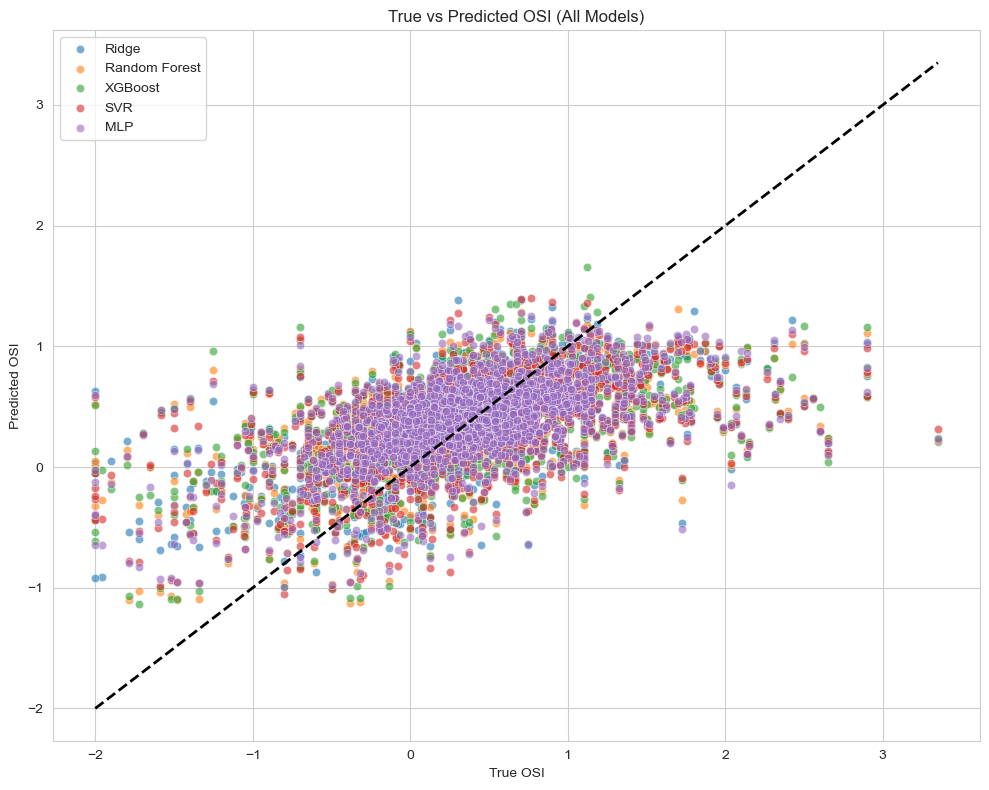

In [10]:
# Figure 1: Scatter Plot of True vs Predicted Values (All Models)
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of true values vs predicted values
model_preds = {
    "Ridge": y_pred_lr,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb,
    "SVR": y_pred_svr,
    "MLP": y_pred_mlp
}

plt.figure(figsize=(10, 8))
for model_name, preds in model_preds.items():
    sns.scatterplot(x=y_test, y=preds, label=model_name, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("True OSI")
plt.ylabel("Predicted OSI")
plt.title("True vs Predicted OSI (All Models)")
plt.legend()
plt.grid(True)

# Save the plot
plt.tight_layout()
plt.savefig("true_vs_predicted_all_models.png", dpi=300)
plt.show()

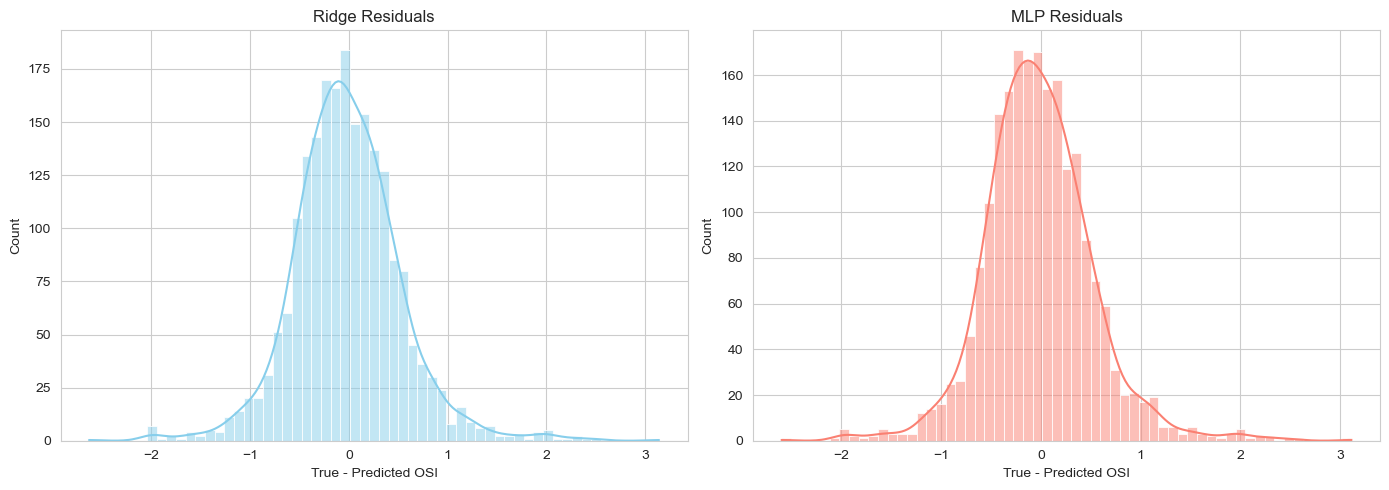

In [11]:
# Figure 2: Residuals Distribution Plot (Ridge & MLP)
# Residuals plot (True - Predicted)

residual_ridge = y_test - y_pred_lr
residual_mlp = y_test - y_pred_mlp

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(residual_ridge, kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Ridge Residuals")
axes[0].set_xlabel("True - Predicted OSI")

sns.histplot(residual_mlp, kde=True, ax=axes[1], color="salmon")
axes[1].set_title("MLP Residuals")
axes[1].set_xlabel("True - Predicted OSI")

# Save the plot
plt.tight_layout()
plt.savefig("residuals_ridge_mlp.png", dpi=300)
plt.show()

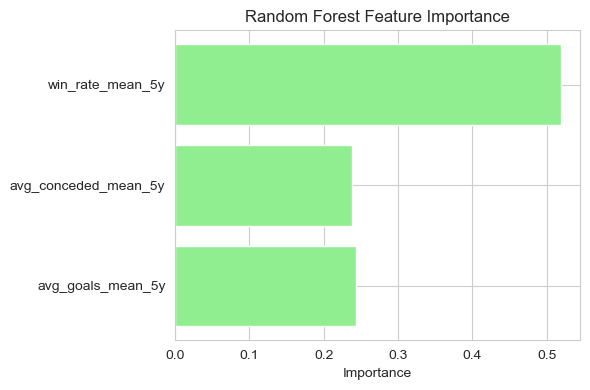

<Figure size 600x400 with 0 Axes>

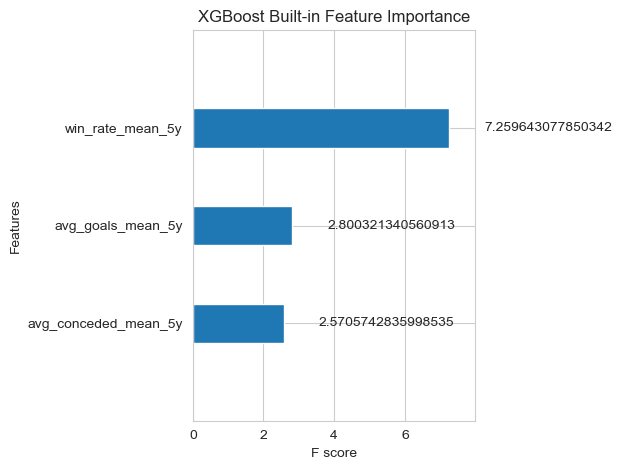

In [12]:
# Figure 3: Feature Importance Plot (Random Forest & XGBoost)
# ===============================================

import matplotlib.pyplot as plt
import numpy as np
from xgboost import plot_importance

# Feature names
feature_names = ["avg_goals_mean_5y", "avg_conceded_mean_5y", "win_rate_mean_5y"]

# 🌳 Random Forest feature importance plot
rf_importance = model_rf.feature_importances_

plt.figure(figsize=(6, 4))
plt.barh(feature_names, rf_importance, color="lightgreen")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")

# Save Random Forest plot
plt.tight_layout()
plt.savefig("feature_importance_rf.png", dpi=300)
plt.show()

# 🔥 XGBoost feature importance plot (using built-in method)
plt.figure(figsize=(6, 4))
plot_importance(model_xgb, importance_type='gain', height=0.4, show_values=True)
plt.title("XGBoost Built-in Feature Importance")

# Save XGBoost plot
plt.tight_layout()
plt.savefig("feature_importance_xgb.png", dpi=300)
plt.show()